In [34]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch import nn, optim
from transformers import AutoImageProcessor, AutoModelForImageClassification # ### 수정 ###: transformers 대신 timm 사용
from torchvision.transforms import InterpolationMode
import timm # ### 추가 ###: timm 라이브러리 임포트
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # ### 추가 ###: 이 줄을 넣어주세요
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from pathlib import Path
from ultralytics import YOLO
import numpy as np
import cv2

from torchvision.transforms import RandAugment
from torch.cuda.amp import autocast, GradScaler


import os
import math


torch.backends.cudnn.benchmark = True



In [35]:
# ### 추가 ###: CoAtNet (및 대부분의 timm 모델)이 요구하는 표준 ImageNet 정규화 값
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

object_det_model = YOLO("yolov8x.pt")

In [36]:
def rotate(img, angle):
    if angle == 0:
        return img
    h, w = img.size[1], img.size[0]
    m = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    rad = np.radians(angle)
    nw = int(abs(np.sin(rad)) * h + abs(np.cos(rad)) * w)
    nh = int(abs(np.cos(rad)) * h + abs(np.sin(rad)) * w)
    m[0, 2] += (nw - w) / 2
    m[1, 2] += (nh - h) / 2
    return Image.fromarray(cv2.warpAffine(np.array(img), m, (nw, nh)))

In [37]:
def detect_best_class(model, img_path):
    img = Image.open(img_path).convert("RGB")
    angles = [0, 45, 90, 180]

    best = {"cls": None, "conf": 0}

    for a in angles:
        rimg = rotate(img, a)
        res = model(rimg)[0]

        if res.boxes:
            for b in res.boxes:
                conf = float(b.conf)
                cls = int(b.cls)

                if conf > best["conf"]:
                    best.update({"cls": cls, "conf": conf})

    if best["cls"] is None:
        return "None"

    return model.names[best["cls"]]

In [38]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(tensor + noise, 0., 1.)

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=InterpolationMode.BICUBIC),

    # 무작위 회전 (30, 45, 60도 중 하나)
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.RandomRotation(45),
        transforms.RandomRotation(60),
        transforms.RandomRotation(75),
        transforms.RandomRotation(90),
        transforms.RandomRotation(120),
        transforms.RandomRotation(150),
        transforms.RandomRotation(180),
        transforms.RandomRotation(210),
        transforms.RandomRotation(240),
        transforms.RandomRotation(270),
        transforms.RandomRotation(300)
    ]),

    # 좌우 / 상하 반전
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    # 30% 확률로 흑백화
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.3),

    transforms.ToTensor(),

    # 가우시안 노이즈 추가
    AddGaussianNoise(0., 0.05),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # ### 추가 ###: 정규화
])

# 검증 및 테스트용은 변형 최소화 (노이즈, 회전 등 제외)
test_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # ### 추가 ###: 정규화
])

In [40]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_encoder=None):
        df = pd.read_csv(csv_file).copy()
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = label_encoder

        # 라벨 인코딩
        if 'target' in df.columns and label_encoder is not None:
            df['target'] = label_encoder.transform(df['target'])

        # 여러 후보 경로에서 첫 번째로 존재하는 경로를 선택
        def resolve_path(rel):
            rel = str(rel)
            candidates = [
                os.path.join(self.root_dir, rel),                          # data/ID
                os.path.join(self.root_dir, "train_offline_aug", rel),     # data/train_offline_aug/ID
                os.path.join(self.root_dir, "train", rel),                 # data/train/ID
                os.path.join(self.root_dir, "test", rel),                  # 🔴 추가: data/test/ID
                os.path.join("/root/cv_project/datasets/data/train_offline_aug", rel),
                os.path.join("/root/cv_project/datasets/data/train", rel),
                os.path.join("/root/cv_project/datasets/data/test", rel),  # 🔴 추가: 절대경로 test
            ]
            # ID가 'train/xxx.jpg' 같은 형태라면 그대로도 시도
            if rel.startswith("train/") or rel.startswith("train_offline_aug/"):
                candidates.insert(0, os.path.join("/root/cv_project/datasets/data", rel))
                candidates.insert(0, os.path.join(self.root_dir, rel))

            for p in candidates:
                if os.path.exists(p):
                    return p
            return None

        df['__path__'] = df['ID'].apply(resolve_path)
        missing = df['__path__'].isna().sum()
        if missing > 0:
            print(f"⚠️ 누락 이미지 {missing}개 스킵 (csv={csv_file})")
            # 디버깅 원하면 어떤 ID가 빠졌는지 출력:
            # print(df[df['__path__'].isna()]['ID'].head(20).tolist())
        df = df.dropna(subset=['__path__']).reset_index(drop=True)
        self.data = df

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row['__path__']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if 'target' in self.data.columns:
            label = torch.tensor(row['target'], dtype=torch.long)
            return img, label
        else:
            return img, -1


In [41]:
train_df = pd.read_csv("/root/cv_project/datasets/data/train.csv")
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df['target'])
num_classes = len(le.classes_) # ### 수정 ###: 모델 로딩 전에 num_classes 정의

# 학습용(증강 csv)
train_dataset = CustomImageDataset(
    csv_file="/root/cv_project/datasets/data/train_offline_aug.csv",
    root_dir="/root/cv_project/datasets/data",
    transform=train_transform,
    label_encoder=le
)

# 검증용(원본 csv)
val_dataset = CustomImageDataset(
    csv_file="/root/cv_project/datasets/data/train.csv",
    root_dir="/root/cv_project/datasets/data",
    transform=test_transform,
    label_encoder=le
)

# 테스트용
test_dataset = CustomImageDataset(
    csv_file="/root/cv_project/datasets/data/sample_submission.csv",
    root_dir="/root/cv_project/datasets/data",
    transform=test_transform,
    label_encoder=le
)


# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
    num_workers=8, pin_memory=True, persistent_workers=True,
    prefetch_factor=4)

In [42]:
# processor = AutoImageProcessor.from_pretrained("Falconsai/nsfw_image_detection")
# model = AutoModelForImageClassification.from_pretrained("Falconsai/nsfw_image_detection")

# num_classes = len(le.classes_)
# if model.config.num_labels != num_classes:
#     if hasattr(model, 'classifier'):
#         in_features = model.classifier.in_features
#         model.classifier = nn.Linear(in_features, num_classes)
#     elif hasattr(model, 'score'):
#         in_features = model.score.in_features
#         model.score = nn.Linear(in_features, num_classes)
#     else:
#         print("모델 구조 확인 필요 - 마지막 레이어 이름 다를 수 있음")

MODEL_NAME = 'swin_large_patch4_window12_384' # (CoAtNet-0, 224x224, Ross Wightman Pretrained)
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=num_classes,
    drop_path_rate=0.2,
)
model.to(memory_format=torch.channels_last)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [43]:
num_epochs = 15

ACCUMULATION_STEPS = 4

# ### 추가 ###: 검증 버그 수정을 위해 train/val 인덱스 분리 (학습 루프 전으로 이동)
df = pd.read_csv("/root/cv_project/datasets/data/train.csv")
y_all = le.transform(df["target"])
train_idx, val_idx = train_test_split(
    np.arange(len(df)), test_size=0.2, stratify=y_all, random_state=42
)

val_subset = Subset(val_dataset, val_idx)     


train_loader = DataLoader(
    train_dataset,  # ← 증강 전체 사용
    batch_size=4, shuffle=True,
    num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4
)
val_loader = DataLoader(
    val_subset,
    batch_size=16, shuffle=False,
    num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4
)


updates_per_epoch = (len(train_loader) + ACCUMULATION_STEPS - 1) // ACCUMULATION_STEPS
total_updates = num_epochs * updates_per_epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_updates)


best_f1 = -1.0
best_epoch = -1

use_amp = True
scaler = GradScaler(enabled=use_amp)
max_grad_norm = 1.0


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)

        with autocast(enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / ACCUMULATION_STEPS

        scaler.scale(loss).backward()


        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            
            scheduler.step()

        total_loss += loss.item() * ACCUMULATION_STEPS

    if (i + 1) % ACCUMULATION_STEPS != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True) 

        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # ### 추가 ###: 매 에포크마다 검증 실행
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader: # ### 수정 ###: val_loader 사용
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation F1: {val_f1:.4f}")
    # (Early Stopping 로직을 여기에 추가할 수 있습니다)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved new best model (F1={best_f1:.4f}) at epoch {best_epoch}")


# ### 추가 ###: YOLO 추론을 위해 정규화된 텐서를 [0, 255] PIL 이미지로 되돌리는 함수
def denormalize_for_yolo(tensor):
    # (C, H, W) 텐서를 (H, W, C) numpy로
    img_np = tensor.cpu().permute(1, 2, 0).numpy()
    
    # 정규화 되돌리기 (img * std) + mean
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img_np = (img_np * std) + mean
    
    # [0, 1] 범위로 클리핑하고 [0, 255] 범위로 변환
    img_np = np.clip(img_np, 0, 1) * 255
    
    return Image.fromarray(img_np.astype(np.uint8))

/tmp/ipykernel_1762850/483499117.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 1/15 - Loss: 0.7561
Epoch 1/15 - Validation F1: 0.9383
✅ Saved new best model (F1=0.9383) at epoch 1


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 2/15 - Loss: 0.2731
Epoch 2/15 - Validation F1: 0.9530
✅ Saved new best model (F1=0.9530) at epoch 2


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 3/15 - Loss: 0.1857
Epoch 3/15 - Validation F1: 0.9703
✅ Saved new best model (F1=0.9703) at epoch 3


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 4/15 - Loss: 0.1295
Epoch 4/15 - Validation F1: 0.9776
✅ Saved new best model (F1=0.9776) at epoch 4


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 5/15 - Loss: 0.0979
Epoch 5/15 - Validation F1: 0.9778
✅ Saved new best model (F1=0.9778) at epoch 5


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 6/15 - Loss: 0.0660
Epoch 6/15 - Validation F1: 0.9925
✅ Saved new best model (F1=0.9925) at epoch 6


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 7/15 - Loss: 0.0557
Epoch 7/15 - Validation F1: 0.9746


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 8/15 - Loss: 0.0393
Epoch 8/15 - Validation F1: 1.0000
✅ Saved new best model (F1=1.0000) at epoch 8


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 9/15 - Loss: 0.0288
Epoch 9/15 - Validation F1: 0.9866


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 10/15 - Loss: 0.0243
Epoch 10/15 - Validation F1: 0.9971


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 11/15 - Loss: 0.0134
Epoch 11/15 - Validation F1: 0.9941


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 12/15 - Loss: 0.0116
Epoch 12/15 - Validation F1: 0.9971


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 13/15 - Loss: 0.0080
Epoch 13/15 - Validation F1: 1.0000


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 14/15 - Loss: 0.0061
Epoch 14/15 - Validation F1: 0.9971


/tmp/ipykernel_1762850/483499117.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 15/15 - Loss: 0.0115
Epoch 15/15 - Validation F1: 0.9971


In [44]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

from pathlib import Path
Path("output").mkdir(parents=True, exist_ok=True)

all_preds = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        for img_tensor in images:
            # img_np = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            # pil_img = Image.fromarray(img_np)
            pil_img = denormalize_for_yolo(img_tensor)

            yolo_res = object_det_model(pil_img, verbose=False)[0]

            detected_car = False


            # [YOLO RULE] conf 임계치 추가  
            YOLO_CONF_THR = 0.6

            if yolo_res.boxes:
                for box in yolo_res.boxes:
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])
                    class_name = object_det_model.names[cls]

                    if class_name == "car" and conf >= YOLO_CONF_THR:
                        detected_car = True
                        break

            if detected_car:
                all_preds.append(16)
            else:
                img_batch = img_tensor.unsqueeze(0).to(device)
                outputs = model(img_batch) # .logits
                pred_class = outputs.argmax(dim=1).cpu().item()
                all_preds.append(pred_class)

pred_labels = le.inverse_transform(all_preds)

result = pd.read_csv('/root/cv_project/datasets/data/sample_submission.csv')
result['target'] = pred_labels
result.to_csv('output/offlin_10.csv', index=False)
print("✅ 저장 완료: aug_best.csv (best model)")

✅ 저장 완료: aug_best.csv (best model)


              precision  recall  f1-score  support
0                   1.0     1.0       1.0     20.0
1                   1.0     1.0       1.0      9.0
2                   1.0     1.0       1.0     20.0
3                   1.0     1.0       1.0     20.0
4                   1.0     1.0       1.0     20.0
5                   1.0     1.0       1.0     20.0
6                   1.0     1.0       1.0     20.0
7                   1.0     1.0       1.0     20.0
8                   1.0     1.0       1.0     20.0
9                   1.0     1.0       1.0     20.0
10                  1.0     1.0       1.0     20.0
11                  1.0     1.0       1.0     20.0
12                  1.0     1.0       1.0     20.0
13                  1.0     1.0       1.0     15.0
14                  1.0     1.0       1.0     10.0
15                  1.0     1.0       1.0     20.0
16                  1.0     1.0       1.0     20.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0

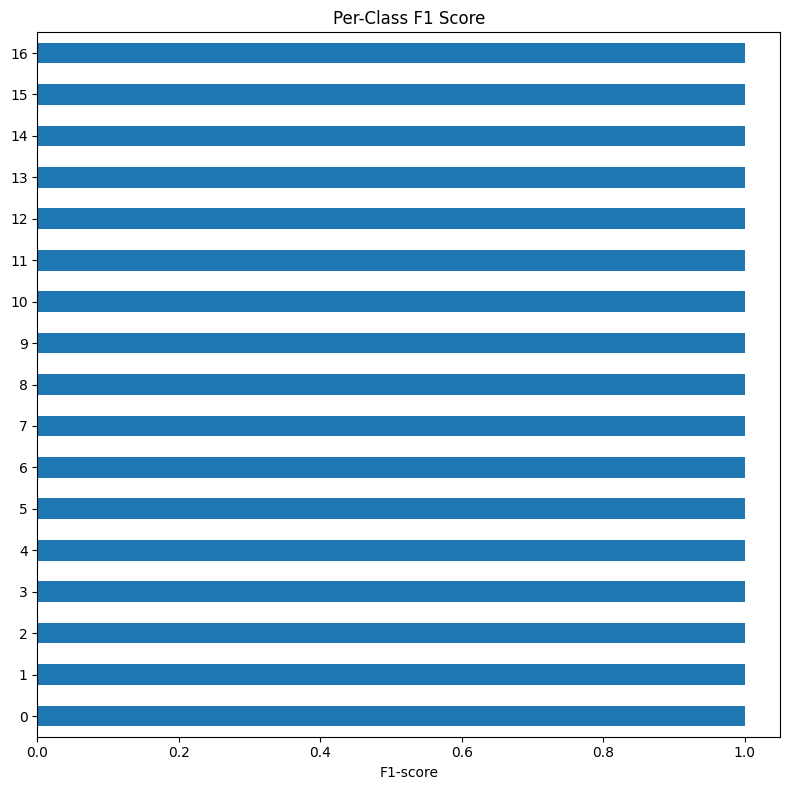

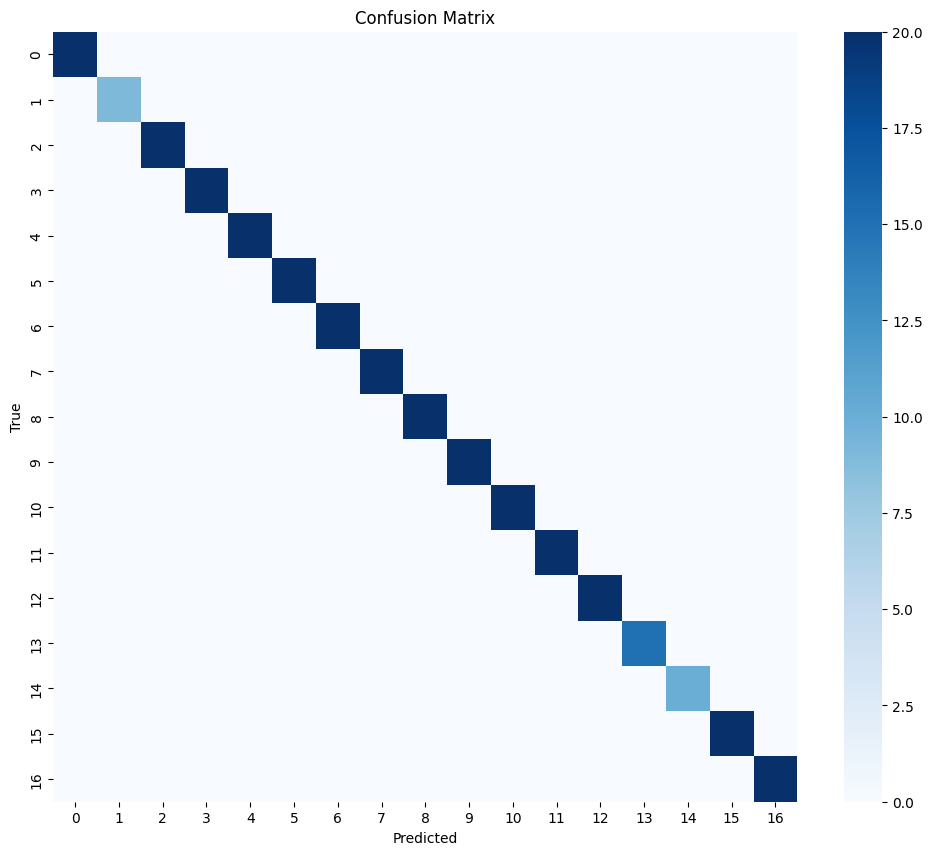

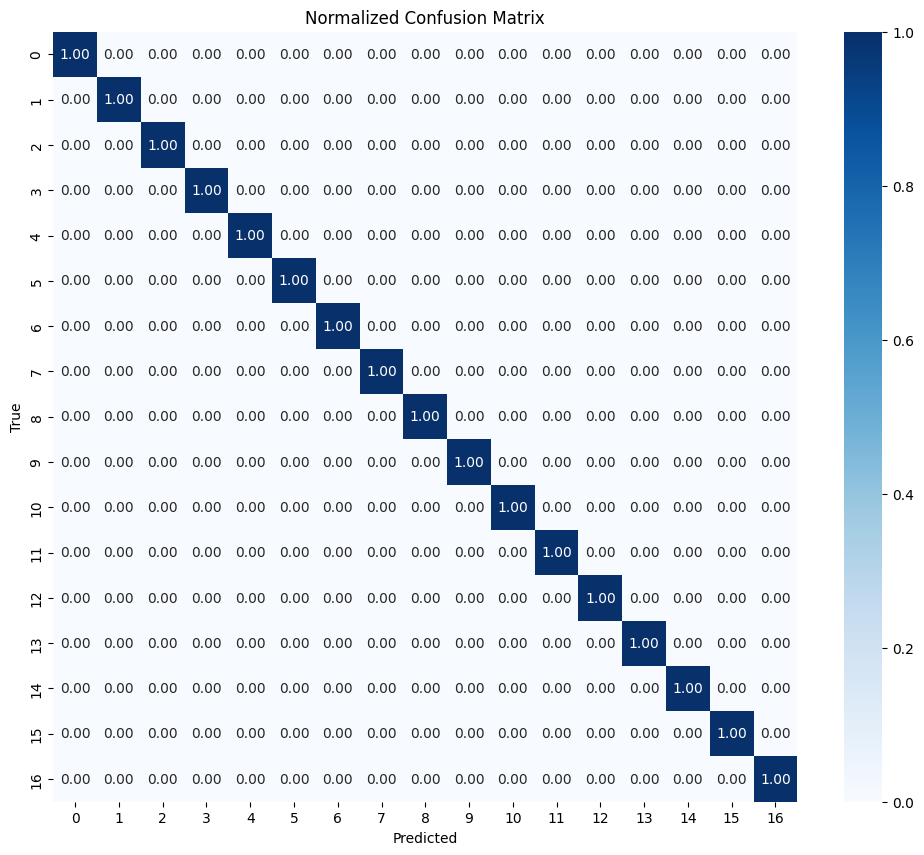

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Subset


# ⚙️ 2. 검증 데이터 예측
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)   # .logits
        preds = logits.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ⚙️ 3. 클래스별 성능표 출력
report = classification_report(
    y_true, y_pred, target_names=le.classes_, output_dict=True, zero_division=0
)
df_report = pd.DataFrame(report).transpose()
print(df_report.round(3))

# ⚙️ 4. 막대 그래프로 시각화
df_report[:-3].sort_values("f1-score", ascending=False)["f1-score"].plot.barh(figsize=(8,8))
plt.title("Per-Class F1 Score")
plt.xlabel("F1-score")
plt.tight_layout()
plt.show()

# ⚙️ 5. 혼동행렬 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ⚙️ 6. 혼동행렬 (정규화 버전)
cmn = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
plt.figure(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
